

<div align="right"> <b>Parin Kittipongdaja<br>
RADS 6136454 RADS/M<br>
RADS 611 Advanced Machine learning <br>
Assignment II </b></div>

# <center>Predict Age from Face Using Deep Learning<center/>


- https://towardsdatascience.com/predict-age-and-gender-using-convolutional-neural-network-and-opencv-fd90390e3ce6

# Methods
1. Download image file from 
    - https://talhassner.github.io/home/projects/Adience/Adience-data.html
- Prepare data by resizing
- Create neural network architecture
- Due to we have imbalamced data, we re-balance it
- Evaluate Model
- Analysis of Error

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import cv2
import sys
import sklearn

print ( "Python", sys.version )
print ( "Numpy", np.__version__ )
print ( "OpenCV", cv2.__version__ )
print ( "sklearn", sklearn.__version__ )
print ( "Tensorflow", tf.__version__ )

Python 3.7.1 (default, Nov  6 2018, 18:45:35) 
[Clang 10.0.0 (clang-1000.11.45.5)]
Numpy 1.14.6
OpenCV 4.1.0
sklearn 0.20.3
Tensorflow 2.0.0-alpha0


In [42]:
# Basic library
import os
import cv2
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from tqdm import tqdm
from itertools import cycle
Fignum = cycle(range(1,20))

# Data preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Developing Model 
# import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten

# Fine-tuning Model
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.externals import joblib

# Evaluation
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [2]:
# Get current directory
import os
os.getcwd()

'/Users/PLoTAir/Google Drive/Data Sci Files/RADS 611 - Adv Model/Face_DL/GCP_file/file-command'

In [3]:
file_list = os.listdir('./fold_file')
file_list

['fold_1_data.txt',
 'fold_0_data.txt',
 'fold_4_data.txt',
 'fold_2_data.txt',
 'fold_3_data.txt']

In [4]:
fold_list = [file for file in file_list if ('fold') in file and ('(old') not in file and ('frontal') not in file]
fold_list.sort()
fold_list

['fold_0_data.txt',
 'fold_1_data.txt',
 'fold_2_data.txt',
 'fold_3_data.txt',
 'fold_4_data.txt']

In [5]:
df_name_list = []
df_list = []
for name in fold_list:
    locals()['df_'+name[:6]] = pd.read_csv('./fold_file/'+name, sep="\t")
    df_name_list.append('df_'+name[:6])
    df_list.append(locals()['df_'+name[:6]])
    
print(df_name_list)
df_list[0].head()

['df_fold_0', 'df_fold_1', 'df_fold_2', 'df_fold_3', 'df_fold_4']


,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


In [6]:
df_list[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4484 entries, 0 to 4483
Data columns (total 12 columns):
user_id               4484 non-null object
original_image        4484 non-null object
face_id               4484 non-null int64
age                   4484 non-null object
gender                4431 non-null object
x                     4484 non-null int64
y                     4484 non-null int64
dx                    4484 non-null int64
dy                    4484 non-null int64
tilt_ang              4484 non-null int64
fiducial_yaw_angle    4484 non-null int64
fiducial_score        4484 non-null int64
dtypes: int64(8), object(4)
memory usage: 420.5+ KB


# Check Number of Each DF(fold)

In [7]:
df_nrow = pd.DataFrame()
for name, df in  zip(df_name_list, df_list):
    n_df = pd.DataFrame(np.array([df.iloc[:,1].count()]),['n_row'], columns=[name]).T
    df_nrow = df_nrow.append(n_df)
df_nrow

,n_row
df_fold_0,4484
df_fold_1,3730
df_fold_2,3894
df_fold_3,3446
df_fold_4,3816


# Check Null Value

In [8]:
df_isnull = pd.DataFrame()
for name, df in  zip(df_name_list, df_list):
    n_df = pd.DataFrame(df.isnull().sum(), columns=[name]).T
    df_isnull = df_isnull.append(n_df)
df_isnull

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
df_fold_0,0,0,0,0,53,0,0,0,0,0,0,0
df_fold_1,0,0,0,0,38,0,0,0,0,0,0,0
df_fold_2,0,0,0,0,541,0,0,0,0,0,0,0
df_fold_3,0,0,0,0,62,0,0,0,0,0,0,0
df_fold_4,0,0,0,0,85,0,0,0,0,0,0,0


# Check 'None' Value

In [9]:
df_isnone = pd.DataFrame()
col_list = df_list[0].columns.tolist()
for name, df in  zip(df_name_list, df_list):
    col_none_list = []
    for col in col_list:
        none_count = list(df[col].values).count('None')
        col_none_list.append(none_count)
    n_df = pd.DataFrame(col_none_list, columns=[name]).T
    df_isnone = df_isnone.append(n_df)
df_isnone.columns = col_list
df_isnone

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
df_fold_0,0,0,0,52,0,0,0,0,0,0,0,0
df_fold_1,0,0,0,37,0,0,0,0,0,0,0,0
df_fold_2,0,0,0,551,0,0,0,0,0,0,0,0
df_fold_3,0,0,0,46,0,0,0,0,0,0,0,0
df_fold_4,0,0,0,62,0,0,0,0,0,0,0,0


# Check Duplicate Row

In [10]:
df_isdup = pd.DataFrame()
for name, df in  zip(df_name_list, df_list):
    n_df = df[df.duplicated()]
    df_isdup = df_isdup.append(n_df)
df_isdup

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score


# Mangaging Group

In [12]:
df_fold_0['age'].value_counts()

(25, 32)     1646
(0, 2)        960
(38, 43)      554
(4, 6)        494
(48, 53)      219
(8, 12)       213
(15, 20)      152
(60, 100)     139
None           52
35             24
3              13
55              6
36              4
13              3
58              2
45              1
(38, 48)        1
22              1
Name: age, dtype: int64

In [13]:
sorted(df_fold_0['age'].value_counts().index)

['(0, 2)',
 '(15, 20)',
 '(25, 32)',
 '(38, 43)',
 '(38, 48)',
 '(4, 6)',
 '(48, 53)',
 '(60, 100)',
 '(8, 12)',
 '13',
 '22',
 '3',
 '35',
 '36',
 '45',
 '55',
 '58',
 'None']

In [14]:
list(df_fold_0['age'].unique())

['(25, 32)',
 '(38, 43)',
 '(4, 6)',
 '(60, 100)',
 '(15, 20)',
 '(48, 53)',
 '(8, 12)',
 '(0, 2)',
 'None',
 '(38, 48)',
 '35',
 '3',
 '55',
 '58',
 '22',
 '13',
 '45',
 '36']

In [19]:
age_group = []
for df in df_list:
    age_group.extend(list(df['age'].unique()))
# age_group = [list(df['age'].unique()) for df in df_list]
count_age = Counter(age_group)
count_age

Counter({'(25, 32)': 5,
         '(38, 43)': 5,
         '(4, 6)': 5,
         '(60, 100)': 5,
         '(15, 20)': 5,
         '(48, 53)': 5,
         '(8, 12)': 5,
         '(0, 2)': 5,
         'None': 5,
         '(38, 48)': 2,
         '35': 5,
         '3': 3,
         '55': 5,
         '58': 2,
         '22': 4,
         '13': 3,
         '45': 5,
         '36': 2,
         '23': 3,
         '(38, 42)': 2,
         '(8, 23)': 1,
         '(27, 32)': 2,
         '57': 3,
         '56': 1,
         '2': 1,
         '29': 1,
         '34': 1,
         '42': 1,
         '46': 1,
         '32': 1})

In [20]:
sorted_count_age = sorted(sorted(count_age.items(), key = lambda kv: kv[1], reverse=True)[:12])
sorted_count_age[:8]

[('(0, 2)', 5),
 ('(15, 20)', 5),
 ('(25, 32)', 5),
 ('(38, 43)', 5),
 ('(4, 6)', 5),
 ('(48, 53)', 5),
 ('(60, 100)', 5),
 ('(8, 12)', 5)]

In [21]:
age_list = [x[0] for x in sorted_count_age[:8]]
sort_age_list = sorted(age_list, key = lambda el: int(el[1]+el[2]) 
                                       if el[2].isalnum() else int(el[1])  , reverse=False)
sort_age_list

['(0, 2)',
 '(4, 6)',
 '(8, 12)',
 '(15, 20)',
 '(25, 32)',
 '(38, 43)',
 '(48, 53)',
 '(60, 100)']

# Remove Uncommon Age group

In [22]:
def remove_unlabel(df, age_list):
    sort_age_list = sorted(age_list, 
                           key = lambda el: int(el[1]+el[2]) 
                           if el[2].isalnum() else int(el[1]), 
                           reverse=False)
    # Dict comprehension to genearate dict of interest with categories
    dict_age = {age:i for i,age in enumerate(sort_age_list)}
    
    # Check whether age is in dict
    df['age_filter'] = df['age'].apply(lambda x: int(x in dict_age))
    df = df[df['age_filter'] == 1]
    return df
# remove_unlabel(df_fold_0, age_list)['age_filter'].value_counts()   
remove_unlabel(df_fold_0, age_list).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4377 entries, 0 to 4481
Data columns (total 13 columns):
user_id               4377 non-null object
original_image        4377 non-null object
face_id               4377 non-null int64
age                   4377 non-null object
gender                4376 non-null object
x                     4377 non-null int64
y                     4377 non-null int64
dx                    4377 non-null int64
dy                    4377 non-null int64
tilt_ang              4377 non-null int64
fiducial_yaw_angle    4377 non-null int64
fiducial_score        4377 non-null int64
age_filter            4377 non-null int64
dtypes: int64(9), object(4)
memory usage: 478.7+ KB


In [23]:
df_list_re = []
for df_name in df_name_list:
    locals()[df_name] = remove_unlabel(locals()[df_name], age_list)
    df_list_re.append(locals()[df_name])
df_list_re[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4377 entries, 0 to 4481
Data columns (total 13 columns):
user_id               4377 non-null object
original_image        4377 non-null object
face_id               4377 non-null int64
age                   4377 non-null object
gender                4376 non-null object
x                     4377 non-null int64
y                     4377 non-null int64
dx                    4377 non-null int64
dy                    4377 non-null int64
tilt_ang              4377 non-null int64
fiducial_yaw_angle    4377 non-null int64
fiducial_score        4377 non-null int64
age_filter            4377 non-null int64
dtypes: int64(9), object(4)
memory usage: 478.7+ KB


In [24]:
print(*df_name_list)

df_fold_0 df_fold_1 df_fold_2 df_fold_3 df_fold_4


# Combine All DataFrame

In [25]:
df_all = pd.concat([df_fold_0, df_fold_1, df_fold_2, df_fold_3, df_fold_4], axis = 0)
df_all = df_all.reset_index(drop=True)
display(df_all.shape)
df_all.drop_duplicates(subset=['user_id', 'original_image', 'face_id'], inplace=True)
df_all.info()

(17393, 13)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17393 entries, 0 to 17392
Data columns (total 13 columns):
user_id               17393 non-null object
original_image        17393 non-null object
face_id               17393 non-null int64
age                   17393 non-null object
gender                17327 non-null object
x                     17393 non-null int64
y                     17393 non-null int64
dx                    17393 non-null int64
dy                    17393 non-null int64
tilt_ang              17393 non-null int64
fiducial_yaw_angle    17393 non-null int64
fiducial_score        17393 non-null int64
age_filter            17393 non-null int64
dtypes: int64(9), object(4)
memory usage: 1.9+ MB


## Save processed fold of All DataFrame

In [26]:
df_all.to_csv('./Data/all_fold.csv', index=False)
df_all.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score,age_filter
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17,1
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94,1
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74,1
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47,1
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34,1


## Import All DataFrame

In [27]:
all_fold = pd.read_csv('./Data/all_fold.csv')
all_fold.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score,age_filter
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17,1
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94,1
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74,1
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47,1
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34,1


# Read image and Load into dataframe

In [32]:
def create_path(df, base_path):

    df['path'] = df.apply(lambda x: base_path+"aligned/"+x['user_id']+"/landmark_aligned_face.%s.%s"
                                                                      %(x['face_id'], x['original_image']), axis=1)
    return df

In [33]:
def read_and_resize(filepath, dsize = (256,256)):
    img = cv2.imread(filepath)
    # perform the actual resizing of the image
    resized = cv2.resize(img, dsize = dsize, interpolation = cv2.INTER_AREA)
    return resized

In [34]:
base_path = './'
all_fold = create_path(all_fold, base_path)
all_fold.head().append(all_fold.tail())

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score,age_filter,path
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17,1,./aligned/30601258@N03/landmark_aligned_face.1...
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94,1,./aligned/30601258@N03/landmark_aligned_face.2...
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74,1,./aligned/30601258@N03/landmark_aligned_face.1...
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47,1,./aligned/30601258@N03/landmark_aligned_face.3...
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34,1,./aligned/30601258@N03/landmark_aligned_face.2...
17388,101515718@N03,10587826073_6663f5b654_o.jpg,2280,"(25, 32)",f,718,748,492,492,0,0,63,1,./aligned/101515718@N03/landmark_aligned_face....
17389,101515718@N03,10587571495_a61785cd06_o.jpg,2278,"(25, 32)",m,48,472,768,768,-15,0,25,1,./aligned/101515718@N03/landmark_aligned_face....
17390,101515718@N03,10587571495_a61785cd06_o.jpg,2279,"(25, 32)",f,950,0,692,687,-5,0,27,1,./aligned/101515718@N03/landmark_aligned_face....
17391,50458575@N08,9426695459_9e8b347604_o.jpg,2281,"(25, 32)",f,831,895,899,899,0,15,59,1,./aligned/50458575@N08/landmark_aligned_face.2...
17392,50458575@N08,9429464468_1bfc39ecfb_o.jpg,2281,"(25, 32)",f,653,1023,555,554,5,30,70,1,./aligned/50458575@N08/landmark_aligned_face.2...


# Save the dataframe with image to disk

In [4]:
# Load the dataframe with image to kernel
start = time()
# path = '/Users/PLoTAir/Desktop/assignment'
filename_path = './Data/GoogleNet_fold_32.pkl'
df_images = joblib.load(filename_path)

t = time() - start
print('Execution time = ', t, ' seconds')

Execution time =  7.293017148971558  seconds


In [38]:
df_images = all_fold.copy()
dict_age = {'(0, 2)' : 0, '(4, 6)' : 1, '(8, 12)' : 2, '(15, 20)' : 3,
            '(25, 32)' : 4,'(38, 43)' : 5,'(48, 53)' : 6,'(60, 100)' : 7}

df_images['age_class'] = df_images['age'].apply(lambda x: dict_age[x])
dict_age_inv = {}
for key, val in dict_age.items():
#     print(key, val)
    dict_age_inv[val] = key
dict_age_inv

{0: '(0, 2)',
 1: '(4, 6)',
 2: '(8, 12)',
 3: '(15, 20)',
 4: '(25, 32)',
 5: '(38, 43)',
 6: '(48, 53)',
 7: '(60, 100)'}

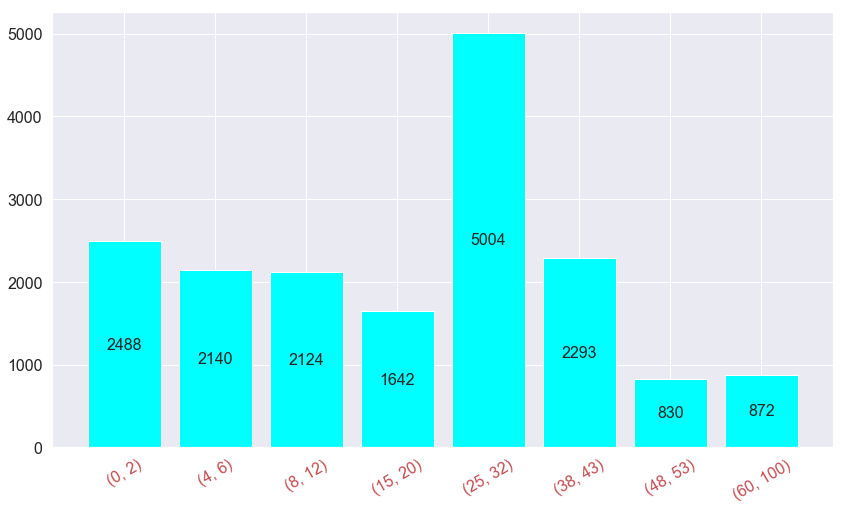

In [41]:
count = df_images['age_class'].value_counts()
count_10 = count[:10]
sns.set()
fig = plt.figure(figsize=(14,8))
ax = plt.bar(x=count_10.index, height=count_10, color='cyan')
plt.xticks(ticks=np.arange(8), labels=dict_age.keys(), rotation=30, color='r', size=16)
plt.yticks(size=16)

for i,j in zip(count_10.index,count_10):
    plt.text(x = i, y=j/2, s=j, 
             horizontalalignment='center', 
             verticalalignment='center', 
             size = 16)
plt.show()

# Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=6,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1)

def augment(im_array):
    im_array = datagen.random_transform(im_array)
    return im_array

datagen2 = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

def augment2(im_array):
    im_array = datagen2.random_transform(im_array, seed=7)
    return im_array

datagen3 = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True)

def augment3(im_array):
    im_array = datagen3.random_transform(im_array, seed=7)
    return im_array

# # https://medium.com/@arindambaidya168/https-medium-com-arindambaidya168-using-keras-imagedatagenerator-b94a87cdefad
# image_gen = ImageDataGenerator(rotation_range=15,
#                                width_shift_range=0.1,
#                                height_shift_range=0.1,
#                                shear_range=0.01,
#                                zoom_range=[0.9, 1.25],
#                                horizontal_flip=True,
#                                vertical_flip=False,
#                                fill_mode='reflect',
#                                data_format='channels_last',
#                                brightness_range=[0.5, 1.5])

# def augment3(im_array, seed_num=7):
#     im_array = image_gen.random_transform(im_array, seed=seed_num)
#     return im_array

In [ ]:
# Split data to train and test
def split_data(X, y, test_size=0.2, seed=7):
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
    print("Size of training data is " + str(X_trn.shape))
    #y_trn_bin = to_categorical(y_trn)
    print("Size of training label is " + str(y_trn.shape))
    unique, counts = np.unique(y_trn, return_counts=True)
    print('Class Counts:',np.asarray((unique, counts)).T.ravel())
    print()
    print("Size of testing data is " + str(X_tst.shape))
    #y_tst_bin = to_categorical(y_tst)
    print("Size of testing label is " + str(y_tst.shape))
    unique, counts = np.unique(y_tst, return_counts=True)
    print('Class Counts:',np.asarray((unique, counts)).T.ravel())
    print()
    unique, counts = np.unique(y, return_counts=True)
    print('Total Class Counts:',np.asarray((unique, counts)).T.ravel())
    return X_trn, X_tst, y_trn, y_tst

In [8]:
start = time()

seed_num = 7
df_train, df_test  = train_test_split(df_images, test_size=0.1, random_state=seed_num)
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=seed_num)

t = time() - start
print('Execution time = ', t, ' seconds')

Execution time =  0.013472557067871094  seconds


In [10]:
start = time()

df_train['Augment_1'] = df_train['img'].apply(augment)
t1 = time() - start
print('Execution time = ', t1, ' seconds')

df_train['Augment_2'] = df_train['img'].apply(augment2)
t2 = time() - start
print('Execution time = ', t2, ' seconds')

df_train['Augment_3'] = df_train['img'].apply(augment3)

t3 = time() - start
print('Execution time = ', t3, ' seconds')

Execution time =  50.15032386779785  seconds
Execution time =  101.57026481628418  seconds
Execution time =  153.8109073638916  seconds


In [11]:
df_col = ['Augment_img','age_class']
df_aug_1 = df_train.loc[:,['Augment_1','age_class']].copy()
df_aug_1.columns = df_col
df_aug_2 = df_train.loc[:,['Augment_2','age_class']].copy()
df_aug_2.columns = df_col
df_aug_3 = df_train.loc[:,['Augment_3','age_class']].copy()
df_aug_3.columns = df_col

# Combine all of dataframe into one
df_img_aug = pd.concat([df_aug_1, df_aug_2], axis=0, ignore_index=True)
df_img_aug = pd.concat([df_img_aug, df_aug_3], axis=0, ignore_index=True)

df_img_aug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42261 entries, 0 to 42260
Data columns (total 2 columns):
Augment_img    42261 non-null object
age_class      42261 non-null int64
dtypes: int64(1), object(1)
memory usage: 660.5+ KB


In [13]:
aug_count = df_img_aug['age_class'].value_counts()
n_min_aug = aug_count.min()
n_min_aug

2016

In [15]:
df_img_aug_bal = pd.DataFrame(columns=df_col)
for idx in aug_count.index:
#     print(idx)
    df_temp = df_img_aug[df_img_aug['age_class']==idx].copy()
#     print(df_temp.info())
    df_img_aug_bal = df_img_aug_bal.append(df_temp.sample(n = n_min_aug, replace = None, random_state = seed_num),ignore_index=True)
df_img_aug_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16128 entries, 0 to 16127
Data columns (total 2 columns):
Augment_img    16128 non-null object
age_class      16128 non-null object
dtypes: object(2)
memory usage: 252.1+ KB


In [17]:
df_model = df_img_aug_bal.copy()

In [18]:
df_model['age_class'].value_counts()

7    2016
6    2016
5    2016
4    2016
3    2016
2    2016
1    2016
0    2016
Name: age_class, dtype: int64

In [20]:
start = time()

seed_num = 7
X = df_model['Augment_img'].values
X_aug_4D = np.array(list(X))
y_aug = df_model['age_class'].values
y_aug_cat = to_categorical(y_aug, num_classes=8)

t = time() - start
print('Execution time = ', t, ' seconds')

Execution time =  2.03572416305542  seconds


In [21]:
print(X_aug_4D.shape, X_aug_4D.dtype)
print(y_aug_cat.shape)

(16128, 128, 128, 3) uint8
(16128, 8)


In [26]:
# Set Callbacks for Model_a
checkpoint_cb = ModelCheckpoint("./Model_report/model_GLN_6.h5", monitor='val_acc', save_best_only=True, verbose = 1)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10, min_delta = 0.001, restore_best_weights=True)
class_weights = class_weight.compute_class_weight('balanced',np.unique(Y),Y)

In [27]:
from Source_code.minigooglenet import MiniGoogLeNet

# check to see if we are compiling using just a single GPU
if num_gpu <= 1:
    print("[INFO] training with 1 GPU...")
    num_gpu = 1
    model = MiniGoogLeNet.build(width=32, height=32, depth=3, classes=8)
#     model = tf.keras.Model(inputs=inputs, outputs=predictions)
    
# otherwise, we are compiling using multiple GPUs
else:
    print("[INFO] training with {} GPUs...".format(num_gpu))

    # we'll store a copy of the model on *every* GPU and then combine
    # the results from the gradient updates on the CPU
    with tf.device("/cpu:0"):
        # initialize the model
        model = MiniGoogLeNet.build(width=32, height=32, depth=3, classes=8)
#         model = tf.keras.Model(inputs=inputs, outputs=predictions)
    
    # make the model parallel
#     model = multi_gpu_model(model, gpus=G)
    model = multi_gpu_model(model, gpus=num_gpu)
    

[INFO] training with 1 GPU...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [28]:
from keras.callbacks import LearningRateScheduler

# definine the total number of epochs to train for along with the
# initial learning rate
NUM_EPOCHS = 100
INIT_LR = 5e-3

def poly_decay(epoch):
	# initialize the maximum number of epochs, base learning rate,
	# and power of the polynomial
	maxEpochs = NUM_EPOCHS
	baseLR = INIT_LR
	power = 1.0

	# compute the new learning rate based on polynomial decay
	alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power

	# return the new learning rate
	return alpha


# construct the image generator for data augmentation and construct
# the set of callbacks
aug = ImageDataGenerator(width_shift_range=0.1,
	height_shift_range=0.1, horizontal_flip=True,
	fill_mode="nearest")
# callbacks = [LearningRateScheduler(poly_decay), checkpoint_cb]
callbacks = [LearningRateScheduler(poly_decay), checkpoint_cb, early_stopping_cb]

In [29]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 96) 2688        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 96) 384         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 96) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [33]:
from keras.optimizers import SGD
from keras.optimizers import Adam
start = time()

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=INIT_LR, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the network
print("[INFO] training network...")
HM = model.fit_generator(
    aug.flow(X_aug_4D, y_aug_cat, batch_size=64 * num_gpu),
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_aug_4D) // (64 * num_gpu),
    epochs=NUM_EPOCHS,
    workers = 16,
#     use_multiprocessing = True,
    callbacks=callbacks, verbose=1)

t = time() - start
print('Execution time = ', t, ' seconds')

[INFO] compiling model...
[INFO] training network...
Epoch 1/100
252/252 [==============================] - 345s 1s/step - loss: 2.0201 - acc: 0.2348 - val_loss: 1.8179 - val_acc: 0.3161

Epoch 00001: val_acc improved from -inf to 0.31609, saving model to ./Model_report/model_GLN_6.h5
Epoch 2/100
252/252 [==============================] - 339s 1s/step - loss: 1.7862 - acc: 0.3131 - val_loss: 1.9077 - val_acc: 0.2759

Epoch 00002: val_acc did not improve from 0.31609
Epoch 3/100
252/252 [==============================] - 339s 1s/step - loss: 1.6853 - acc: 0.3519 - val_loss: 1.6874 - val_acc: 0.3186

Epoch 00003: val_acc improved from 0.31609 to 0.31865, saving model to ./Model_report/model_GLN_6.h5
Epoch 4/100
252/252 [==============================] - 338s 1s/step - loss: 1.5967 - acc: 0.3816 - val_loss: 1.7497 - val_acc: 0.3072

Epoch 00004: val_acc did not improve from 0.31865
Epoch 5/100
252/252 [==============================] - 338s 1s/step - loss: 1.5170 - acc: 0.4132 - val_loss:

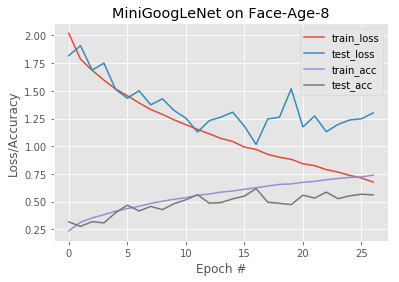

In [34]:
# grab the history object dictionary
H = HM.history

# plot the training loss and accuracy
N = np.arange(0, len(H["loss"]))
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H["loss"], label="train_loss")
plt.plot(N, H["val_loss"], label="test_loss")
plt.plot(N, H["acc"], label="train_acc")
plt.plot(N, H["val_acc"], label="test_acc")
plt.title("MiniGoogLeNet on Face-Age-8")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# save the figure
plt.savefig('./Model_report/report_graph_GLNet_6')
plt.show()
plt.close()

In [36]:
X_test = df_test['img'].values
X_test_4D = np.array(list(X_test))
y_test = df_test['age_class'].values
# df_test.info()
print(X_aug_4D[0].shape)
print(X_test_4D[0].shape)

(128, 128, 3)
(128, 128, 3)


Confusion matrix, without normalization


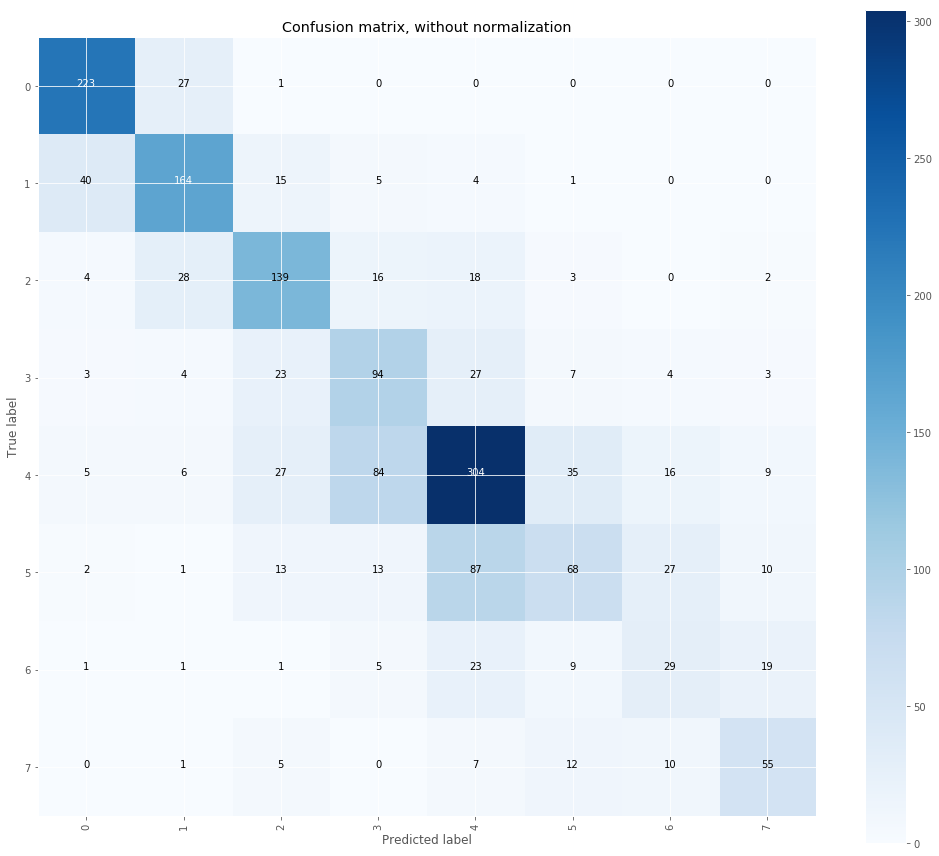

In [37]:
import itertools
label_names = list(set(y_test))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized confusion matrix"
        print(title)
    else:
        title = 'Confusion matrix, without normalization'
        print(title)

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = np.argmax(model.predict(X_test_4D), axis=1);
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(14, 12, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(label_names), normalize=False,
                      title='Normalized confusion matrix')

Normalized confusion matrix


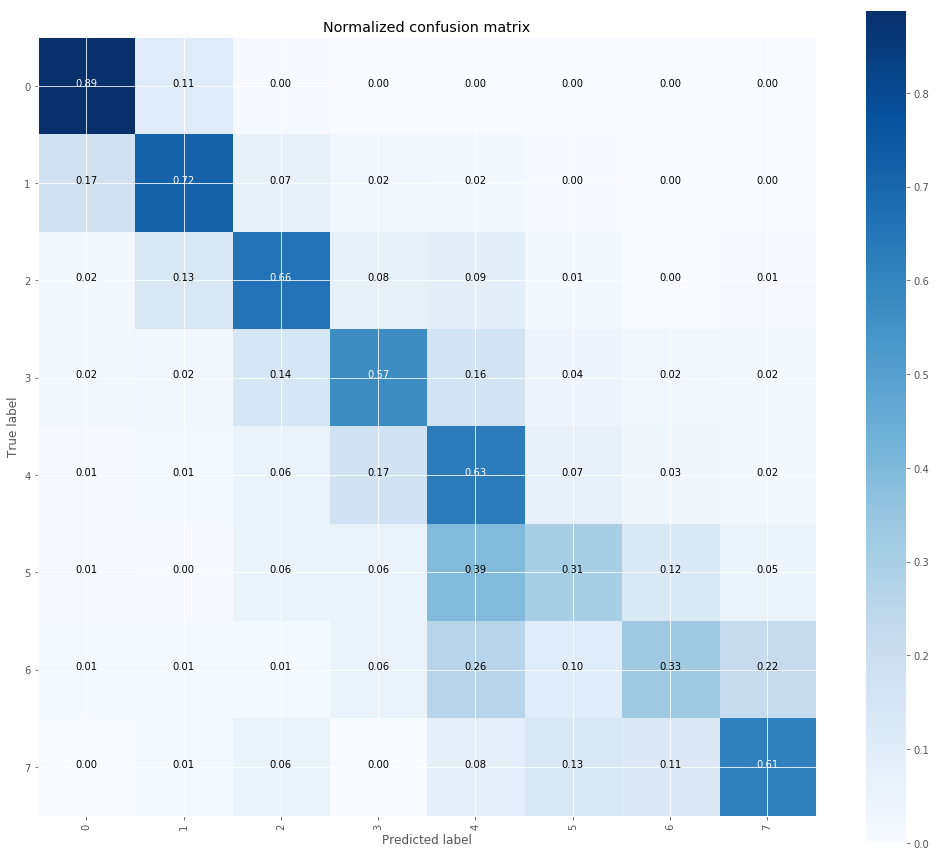

In [38]:
y_pred = np.argmax(model.predict(X_test_4D), axis=1);
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(14, 12, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(label_names), normalize=True,
                      title='Normalized confusion matrix')

# Result

In [43]:
print("Average Accuracy", (0.89+0.72+0.66+0.57+0.63+0.31+0.33+0.61)/8)

Average Accuracy 0.59


From 8 class the model has performance average accuracy equal to 0.59

[('(0, 2)', 0), ('(4, 6)', 1), ('(8, 12)', 2), ('(15, 20)', 3), ('(25, 32)', 4), ('(38, 43)', 5), ('(48, 53)', 6), ('(60, 100)', 7)]


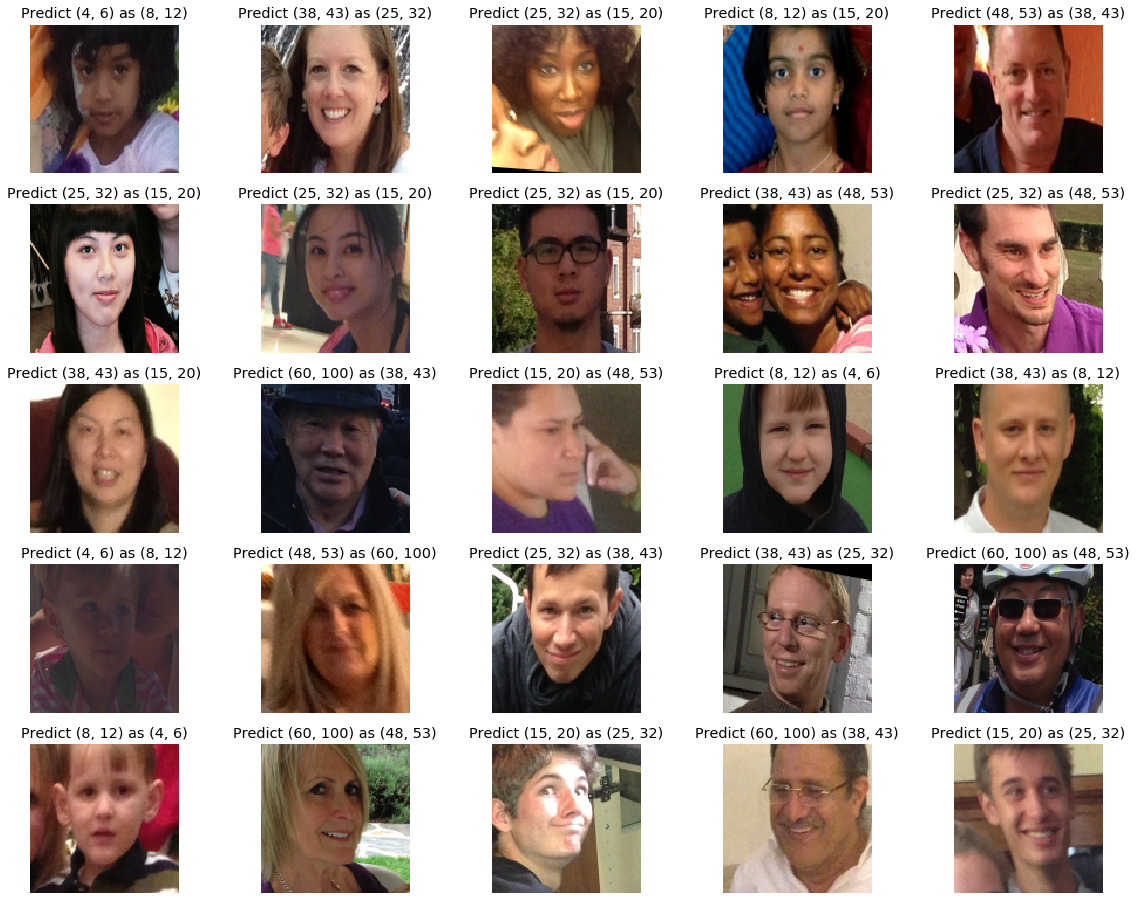

In [41]:
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html
# ypred = np.argmax(predictions, axis=1)
ypred = y_pred
ytrue = y_test
pngs = X_test

# https://www.chegg.com/homework-help/questions-and-answers/working-python-mnist-data-set-numbers-creating-neural-network-issue-following-code-piece-t-q33353531
incorrect_imagenumbers = np.where(ypred!=ytrue)[0] # get indices of incorrect ones
nincorrect = len(incorrect_imagenumbers) 
nsample = 25
samples = np.random.choice(incorrect_imagenumbers, min(nsample,nincorrect), replace=False) 
print(sorted(dict_age.items(), key=lambda kv:kv[1]))
plt.figure(figsize =(20,16)) 
for i,sample in enumerate(samples):  
    #print(i,sample)
    writer = pngs[sample]
    plt.subplot (5,5,i+1) 
    plt.imshow( cv2.cvtColor( writer, cv2.COLOR_BGR2RGB ) )
#     plt.title('Predict ' + str(ytrue[sample]) + ' as ' + str(ypred[sample]) )
    plt.title('Predict ' + dict_age_inv[ytrue[sample]] + ' as ' + dict_age_inv[ypred[sample]] )
    plt.xticks([]) 
    plt.yticks([])

# Analysis of error

It seem like model predict wrong age class in one further step.

# Conclusion

The model is not good enough, we have plenty of room to improve it.